# Raw reads

In [15]:
from Bio import SeqIO
from pathlib import Path
import os

def raw_length_dist(handle, gz=True):
    import gzip
    
    seqLen = []
    if gz:
        with gzip.open(handle, 'rt') as file:
            for record in SeqIO.parse(file, "fastq"):
                seqLen.append(len(record.seq))
    else:
        with open(handle, 'r') as file:
            for record in SeqIO.parse(file, "fastq"):
                seqLen.append(len(record.seq))
    print('Done!')
    return seqLen
    

def get_name(handle):
    import re
    name = re.findall('UM-kSeq-[ABCDE]', handle.as_uri())[0]
    if re.search('R1', handle.as_uri()):
        name += '_forward'
    else:
        name += '_reverse'
    print('File name: %s' %name)
    return name
    

if __name__=='__main__':
    root = '/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq/raw.reads/'
    fileList = list(Path(root).glob("*.fastq*"))
    seqLen = []
    for handle in fileList:
        if handle.match("*.gz"):
            seqLen.append((get_name(handle), raw_length_dist(handle, gz=True)))
        else:
            seqLen.append((get_name(handle), raw_length_dist(handle, gz=False)))



File name: UM-kSeq-B_forward
Done!
File name: UM-kSeq-A_forward
Done!
File name: UM-kSeq-B_reverse
Done!
File name: UM-kSeq-C_reverse
Done!
File name: UM-kSeq-A_reverse
Done!
File name: UM-kSeq-C_forward
Done!
File name: UM-kSeq-D_reverse
Done!
File name: UM-kSeq-D_forward
Done!
File name: UM-kSeq-E_reverse
Done!
File name: UM-kSeq-E_forward
Done!


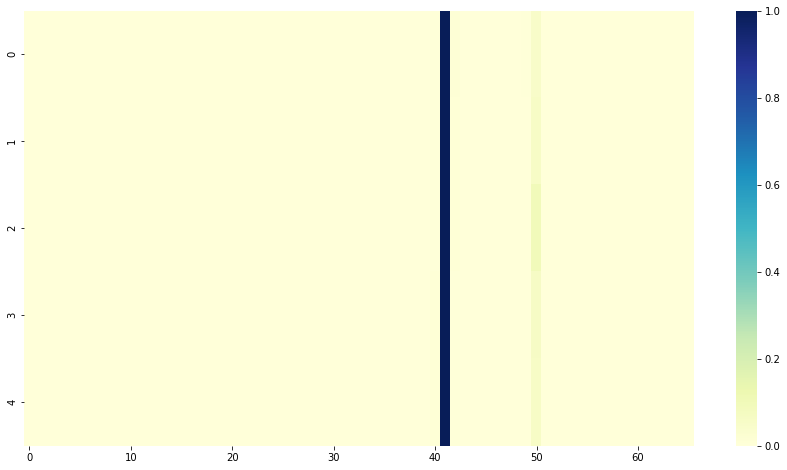

In [19]:
def getKey(entry):
    return entry[0]


def get_counts(lenList):
    import numpy as np
    binList = np.linspace(0, 330, 67)
    return np.histogram(lenList, bins=binList)


if __name__=='__main__':
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    plt.figure(figsize=[15,8])
    seqListSorted = sorted(seqLen, key=getKey)
    forwardMtx = np.asarray([get_counts(seq[1])[0]/np.max(get_counts(seq[1])[0]) for seq in seqListSorted if 'forward' in seq[0]])
    
    sampleNames = [seq[0] for seq in seqListSorted if 'forward' in seq[0]]
    sns.heatmap(forwardMtx, cmap='YlGnBu', xticklabels=10)
    plt.show()
    
    

In [20]:
seqListSorted

[('UM-kSeq-A_forward',
  [207,
   208,
   208,
   207,
   208,
   208,
   207,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   251,
   206,
   209,
   208,
   206,
   208,
   208,
   209,
   208,
   209,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   207,
   208,
   208,
   209,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   207,
   210,
   207,
   208,
   208,
   208,
   208,
   207,
   208,
   206,
   208,
   208,
   207,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   208,
   251,
   208,
   207,
   208,
   208,
   208,
   205,
   208,
   209,
   208,
   208,
   250,
   208,
   209,
   208,
   208,
   208,
   207,
   208,
   208,
   250,
   208,
   209,
   251,
   208,
   208,
   207,
   251,
   208,
   208,
   208,
   209,
   208,
   208,
   208,
   209,
   209,
   208,
   250,
   207,
   208,
   207,
   208,
   208,
   208,
   207,
   208,
   208,
   251,
   206,
   206,
 

# Standard spike-in analysis
## Dispersion of std peak

| sample #| sample | total | unique| std_pct | q_norm_0 | q_norm_1 | q_norm_5 | q_norm_10 |
|:--:|:--|-|-|-|-|-|-|-|-|
|0| UMA_count_final.dat | 42366118 | 37753329 | 0.0011816 | 8.7533260 | 0.0001252 | 0.0001498 | 0.0001525 |
|1| UMB_count_final.dat | 47774717 | 42211052 | 0.0009094 | 4.6880250 | 6.6961614 | 8.0051400 | 8.1401162 |
|2| UMC_combined_count_final.dat | 42083282 | 37292448 | 0.0009451 | 1.9017095 | 2.7126913 | 3.2437834 | 3.3040261 |
|3| UMD_count_final.dat | 46731414 | 41120279 | 0.0010041 | 1.0670787 | 1.5119299 | 1.8015993 | 1.8338455 |
|4| UME_combined_count_final.dat | 40801526 | 36313071 | 0.0010551 | 7.2317175 | 1.0390491 | 1.2465431 | 1.2703129 |


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


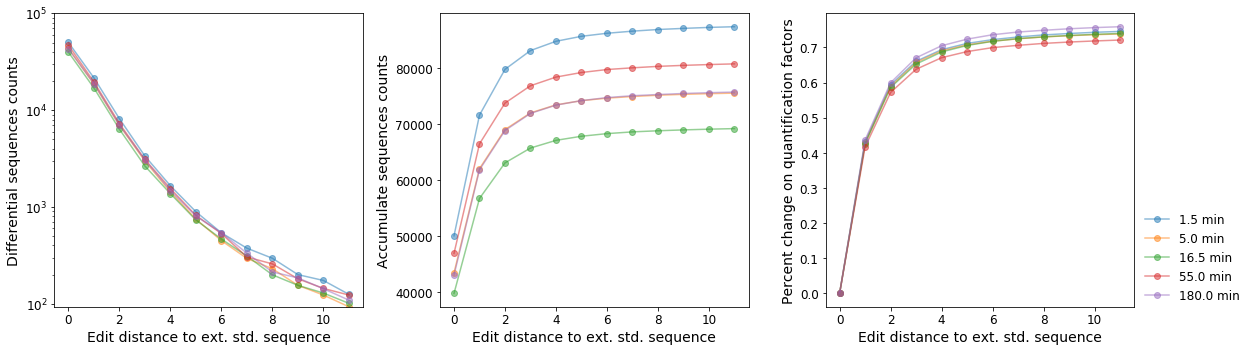

Quantification factors have been saved to /home/yuning/Work/ribozyme_pred/data/uli/


In [3]:
from __future__ import division
from yntools import dump_pickle
import numpy as np

def get_extStd_relaxed_count(sampleDirc, stdSeq):
    from yntools import progress_bar,progress_checkpoint
    import numpy as np
    import Levenshtein
    
    relaxedCounts = [0 for i in range(maxDist + 1)]
    with open(sampleDirc) as file:
        unique = int(next(file).strip().split()[-1])
        total = int(next(file).strip().split()[-1])
        next(file)
        
        checkpoints = progress_checkpoint(unique)
        for ix,line in enumerate(file):
            seq = line.strip().split()
            dist = Levenshtein.distance(stdSeq, seq[0])
            if dist <= maxDist:
                relaxedCounts[dist] += int(seq[1])
            if ix in checkpoints:
                progress_bar(ix/unique)

    print('%s finished!' %sampleDirc)
    return [total, unique, np.asarray(relaxedCounts)]

def test_norm_calculation(extStdCountList):
    
    testNormList = [np.asarray([sum(relaxedCounts[2][:i+1]) for i in range(maxDist+1)])/relaxedCounts[0]/std[sampleIx]
                    for sampleIx,relaxedCounts in enumerate(extStdCountList)]
    print('| sample #| sample | total | unique| std_pct | q_norm_0 | q_norm_1 | q_norm_5 | q_norm_10 |')
    print('|:--:|:--|-|-|-|-|-|-|-|-|')
    for sampleIx,sample in enumerate(kSeqList):
        print('|%i| %s | %i | %i | %.9r | %.9r | %.9r | %.9r | %.9r |' 
              %(sampleIx, sample, extStdCountList[sampleIx][0], extStdCountList[sampleIx][1], 
                extStdCountList[sampleIx][2][0]/extStdCountList[sampleIx][0],
                testNormList[sampleIx][0], testNormList[sampleIx][1], 
                testNormList[sampleIx][5], testNormList[sampleIx][10]))
    return testNormList

def plot(extStdCountList, testNormList):
    import matplotlib.pyplot as plt
    
    symbolList = ['-o', '-s', '->', '-*', '-<', '-v']
    
    plt.figure()
    
    fig, ax = plt.subplots(1,3, figsize=[16,5])
    
    ## Fig a) 
    for sampleIx,sample in enumerate(kSeqList):
        ax[0].plot([i for i in range(maxDist+1)], extStdCountList[sampleIx][2],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    
    ax[0].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[0].tick_params(labelsize=12)
    ax[0].set_yscale('log')
    ax[0].set_ylim([0, 10**5])
    ax[0].set_ylabel('Differential sequences counts', fontsize=14)
    
    ## Fig b)
    for sampleIx,sample in enumerate(kSeqList):
        ax[1].plot([i for i in range(maxDist+1)], [sum(extStdCountList[sampleIx][2][:i+1]) for i in range(maxDist+1)],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    ax[1].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[1].tick_params(labelsize=12)
    # ax[1].set_ylim([0, 3*10**4])
    ax[1].set_ylabel('Accumulate sequences counts', fontsize=14)
    
    ## Fig c)
    for sampleIx,sample in enumerate(kSeqList):
        ax[2].plot([i for i in range(maxDist+1)],
                   (testNormList[sampleIx] - testNormList[sampleIx][0])/testNormList[sampleIx][0],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    ax[2].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[2].tick_params(labelsize=12)
    # ax[2].set_ylim([0, 3*10**4])
    ax[2].set_ylabel('Percent change on quantification factors', fontsize=14)
    ax[2].legend(loc=[1.02,0], fontsize=12, frameon=False)
    
    plt.tight_layout()
    plt.show()

if __name__=='__main__':
    root = '/mnt/chen-nas/SequenceData/07-10-17-BS-UM/'
    kSeqList = ['UMA_count_final.dat', 'UMB_count_final.dat', 'UMC_combined_count_final.dat', 
                'UMD_count_final.dat', 'UME_combined_count_final.dat']
    
    stdSeq = 'TGTTCTAATGCGATACTGTGCGAGACACCATTTAATACGACTGCATACTGTCTCCATCTGACAGGTCCATCCCCCGCTTTCTCGTATTGGATTCGACAAGCCGCGGTCAAATAAACGTCTTACGATAGTACGATACCGTGGGTTGTATTAGACCCGCC'
    maxDist = 11
    timePoints = [1.5, 5, 16.5, 55, 180]
    std = [13.5, 19.4, 49.7, 94.1, 145.9] # unit fmol
    
    stdOutDirc = '/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/'
    
    # extStdCountList = [get_extStd_relaxed_count(root + sample, stdSeq) for sample in kSeqList]
    testNormList = test_norm_calculation(extStdCountList)
    plot(extStdCountList, testNormList)
    
    dump_pickle(extStdCountList, stdOutDirc + 'std_count_list.pkl')
    dump_pickle(testNormList, stdOutDirc + 'q_factor_list.pkl')
    print('Quantification factors have been saved to %s' %'/home/yuning/Work/ribozyme_pred/data/uli/')

# Count table for sequences detected in Round 7-3h

In [4]:
from yntools import load_pickle, dump_pickle
from k_seq import countAll
from __future__ import division


if __name__=='__main__':
    
    root = '/mnt/chen-nas/SequenceData/07-10-17-BS-UM/'
    kSeqList = ['UMA_count_final.dat', 'UMB_count_final.dat', 'UMC_combined_count_final.dat', 
                'UMD_count_final.dat', 'UME_combined_count_final.dat']
    masterDirc = '/home/yuning/Work/ribozyme_pred/data/uli/count-7-3h.txt'

    seqList = {}
    with open(masterDirc) as file:
        unique = int(next(file).strip().split()[-1])
        total = int(next(file).strip().split()[-1])
        next(file)
        for ix,line in enumerate(file):
            seq = line.strip().split()
            seqList['TGTT'+seq[0]+'CGCC'] = [[int(seq[1]), 0, 0, 0, 0, 0], 0]
    
    for sampleIx,sample in enumerate(kSeqList):
        with open(root + sample) as file:
            next(file)
            next(file)
            next(file)
            for ix,line in enumerate(file):
                seq = line.strip().split()
                if seq[0] in seqList:
                    seqList[seq[0]][0][sampleIx+1] = int(seq[1])
                    seqList[seq[0]][1] += 1
    
    # Save count table
    outDirc = '/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/seq_count_raw.pkl'
    dump_pickle(seqList, outDirc)
    print('Sequence counts saved to %s' %outDirc)

Sequence counts saved to /home/yuning/Work/ribozyme_pred/data/uli/hiSeq/seq_count_raw.pkl


[590635, 63297, 37173, 30711, 33368, 90428]


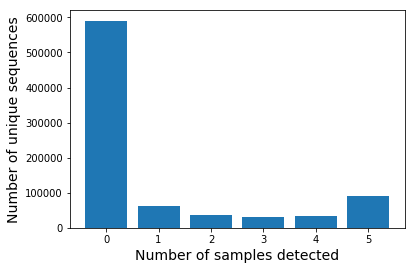

In [5]:
from yntools import load_pickle, dump_pickle
import matplotlib.pyplot as plt

seqList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/seq_count_raw.pkl')
cat = [sum([1 for seq in seqList.values() if seq[1]==i]) for i in range(6)]

print(cat)

plt.figure()
plt.bar([0, 1, 2, 3, 4, 5], cat)
plt.xlabel('Number of samples detected', fontsize=14)
plt.ylabel('Number of unique sequences', fontsize=14)
plt.show()


In [6]:
testSeqs = [
    ['AP10','AGAAACACGTTGGAATGATGGGAATGTCCCATTCCGCGGTCTAAATATGAGTACAGAATAAGAGAACGTTTATATAATAGTGCTCTTGAATAATCCGTTACGGCCGGGATCGACCACGAGATGCCATCGGTGGTTCTTCAGTTTGGCCCT'],
    ['AP12','GGGCCCACGCATGTGCCCCGAGCTCCCACAACTGCGCTGTGCTTTAGTCACAGTGAGGACGTCTACTTGTAACAGCTGACCGTGTCGACGTAGAGACTACTAAGACGCACTCAGCTATGTACACTAGCTCACGCAAATCCGGATTCAACT'],
    ['AP15','ACTACTGGAATGACGTATTTCAATAAGAAAATTAAAGAATGGAAGATTAAGGCACACCTTAGATGACTCCACACCGTAACTTCCCTAACGAGCTGCCACACTGAAACAGCGGTTATCTCTCGGGACTAATCCGTGTCTGTTTCAGGATGA'],
    ['AP19','GAAAGTAAACACCTGTTGTTTCCCGGTATTGAATGCCGCAGCGGGTTGAACTGCATTCCTGGGTCGCGCTTAGGATCCCAGATCCCGACGATTCAGTAAAATCTGCTGCGACGTACGAACTGAAATAATTCATATACGGCCAAGCCTTCT'],
    ['AP20','GGGCCCACGCATGTGCCCCGAGCTCCCACAACTGCGCTGTGCTTTAGTCACAGTGAGGACGTCTACTTGTAACAGCTGACCGTGTCGACGTAGAGACTACTAAGACGCACTCAGCTATGTAATCTAGCTCACGCAAATCCGGATTCAACT'],
    ['AP37','GCAGGAACGAGATGACTCAGAACTGAAATAACAGAACTACGAGGCCATGCAGGCCGCATATCCGCGCGGTATCTGTATATAATCGTAGCCACCATGTGCCGTCCGTAGAAAAACCTAAACGTCAATTGGCAAAAACAGTAATCTTTTTCGA'],
    ['AP40','CGTGCGCGGGCCGCGCTACCCTCACCCGCGTATGATGAAAATGAAATGTTAGCTACGCTCTTTGCGTGTCTGCTTATGACGTTTCCCGAACTTGGAGGCTCGGCCAAGATACAGTACTCCCTTTCAGATAACTACAGTAAGGCCTACTGT'],
    ['AP49','ACCCGATCAACGCGCTGAAAGGTGGTAGCCTATGCGGCTTACCGGTTTATAAAGCGTCTGTGTTTACGATGAGCGATCGATCGATTTCTTCCGCTTCCGCGATATGAAATTGCTCAATAAGTTCTAGCCTTTCCCGCCTACGGATATGTG'],
    ['AP55','GCCCACCGAAAAGCCATCGGGCTGCGTGGAGGAAGAGACTGAGTATAAAACCTCGTACTCTTCTTCCGGATACGCTCGATTTCCACTTCGATTAGGCTGAAACCTGATATGGGCATGAGCGCTCTATTCCCGGAATGGCGAACTATCATCG'],
    ['AP56','CTCTTGTAGTACGGTTGCATGTAATCATAAGCTATATGTACGGAGACTACCGCCAAGACCAAACCTTTGGTTCCCTAAATTGAAAGACTAGTAGCCCAAAAATCAAAATAATAAGGACTTAAGCGAAGACGTCTACCTCTGCCGTTTCCT']
]

for seq in testSeqs:
    print(seqList['TGTT'+seq[1]+'CGCC'])

[[72, 515, 421, 233, 119, 93], 5]
[[21, 251, 234, 103, 64, 44], 5]
[[11, 104, 144, 71, 49, 33], 5]
[[79, 497, 434, 333, 364, 290], 5]
[[48, 615, 568, 262, 162, 88], 5]
[[30, 283, 279, 175, 126, 69], 5]
[[34, 221, 388, 218, 134, 96], 5]
[[404, 3765, 6242, 5327, 4296, 2643], 5]
[[359, 3198, 3320, 2817, 2176, 1269], 5]
[[14, 842, 869, 474, 302, 165], 5]


# Data fitting

In [ ]:
import numpy as np
from yntools import load_pickle, dump_pickle



def normalization():
    seqList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/seq_count_raw.pkl')
    extStdCountList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/std_count_list.pkl')
    qFactorList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/q_factor_list.pkl')
    
    print('Raw sequence counts loaded, converting to normalized ratios...')
    countTable = []
    for seq in seqList.items():
        if seq[1][1]>0:
            countTable.append([seq[0], seq[1][0][0], [seq[1][0][i+1]/(float(extStdCountList[i][0])*qFactorList[i][2])/(seq[1][0][0]/1560875.0*200000.0) for i in range(5)],
                              seq[1][1]])
    print('Sequence counts converted to normalized ratios.')
    return countTable

def fitting(countTable):
    from scipy.optimize import curve_fit
    from yntools import progress_bar, progress_checkpoint
    
    def func(x, A, k):
        return A * (1 - np.exp(- k * x))
    
    xdata = np.array([1.5, 5, 16.5, 55, 180])   # min
    seqNum = len(countTable)
    print('%i sequences to fit...' %seqNum)
    checkpoints = progress_checkpoint(seqNum)
    for ix,seq in enumerate(countTable):
        ydata = np.array(seq[2])
        valid = ydata > 0
        try:
            params, pcov = curve_fit(func, xdata=xdata[valid], ydata=ydata[valid],
                                    method='trf', bounds = ([0,0], [np.inf, np.inf]))
        except RuntimeError:
            params = [np.nan, np.nan]
        seq.append(params)
        if ix in checkpoints:
            progress_bar(ix/len(countTable))
    return countTable
        
if __name__=='__main__':
    
    countTable = normalization()
    countTableFitted = fitting(countTable)
    dump_pickle(countTableFitted, '/home/yuning/Work/ribozyme_pred/data/uli/hiSeq/fitting_results_200000.pkl')

Raw sequence counts loaded, converting to normalized ratios...
Sequence counts converted to normalized ratios.
[                    ] 0%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[=====               ] 24%

In [120]:
[seq[-1] for seq in countTable[:100]]

[array([9.49014824, 1.        ]),
 array([46.53290508,  0.07866778]),
 array([2.40232806, 1.        ]),
 array([6.83835221, 0.20606376]),
 array([5.18332274, 0.0515438 ]),
 array([7.08782018, 1.        ]),
 array([1.06289471, 0.97897747]),
 array([1.06289471, 0.97897747]),
 array([8.46800342, 0.07347065]),
 array([1.06289471, 0.97897747]),
 array([0.80346913, 0.91436929]),
 array([14.17564041,  1.        ]),
 array([2.40232806, 1.        ]),
 array([2.62487372, 0.04486647]),
 array([0.52747568, 2.27384427]),
 array([16.38393646,  0.02071888]),
 array([7.23380504, 0.02057726]),
 array([1.15590541, 0.48757068]),
 array([7.08782018, 1.        ]),
 array([7.08799559, 0.05892683]),
 array([3.80454395, 0.05472092]),
 array([1.3970034, 0.0252278]),
 array([4.80478472, 0.1914259 ]),
 array([1.62922508, 0.13365819]),
 array([9.60931223, 1.        ]),
 array([0.80346913, 0.91436929]),
 array([7.08075031, 0.04826865]),
 array([3.60429811, 0.02097434]),
 array([3.13543621, 0.05670403]),
 array([11